(400, 640)
V:
7.85827646186
7.90952926689
7.98707230247
7.96786903273
7.86237124503
7.97412921714
7.64548003527
7.83404573423
7.97129740689



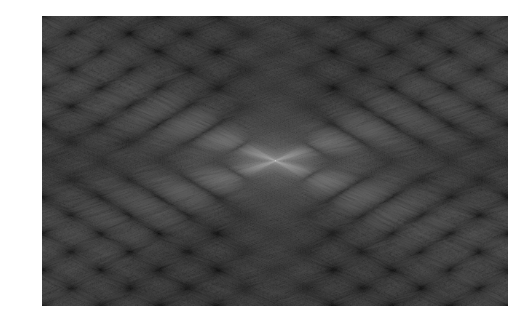

In [1]:
# for python 2 compatibility #
from __future__ import print_function
#                            #
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import math
# %matplotlib inline

letter_list = ['S', 'T', 'V']
k_number_of_images = 10
# get dummy image
avg_img = io.imread('S1.GIF')

# convert to np.array so that we can compute the average  
avg_img_array = np.array(avg_img, dtype=float)
print(avg_img_array.shape)


# 640 x 400 pixels
for letter in letter_list[2]:
    # reset np.array
    avg_img_array.fill(0)
    print(letter + ":")
    for image_index in range(1, k_number_of_images):
        image_name = letter + str(image_index) + '.GIF'
        f = io.imread(image_name)   # read in image

        f_f = np.array(f, dtype=float)
        z = np.fft.fft2(f_f)           # do fourier transform
        q = np.fft.fftshift(z)         # puts u=0,v=0 in the centre

        Magq =  np.absolute(q)         # magnitude spectrum
        log_Magq = np.log(Magq + 1)
        log_Magq_array = np.array(log_Magq, dtype=float)
        
        for idx, pixel in enumerate(log_Magq_array):
            avg_img_array[idx] += pixel
        
        
        Phaseq = np.angle(q)           # phase spectrum

        image_avg_pixel_val = np.mean(log_Magq)
        print(image_avg_pixel_val)
        
    avg_img_array /= k_number_of_images
    
    print()

fig1 = plt.figure()
ax1  = fig1.add_subplot( 111 )
ax1.axis('off')
# Usually for viewing purposes:b
ax1.imshow( avg_img_array, cmap='gray' ) # io.

# fig1 = plt.figure()
# ax1  = fig1.add_subplot( 111 )
# ax1.axis('off')
# Usually for viewing purposes:
# ax1.imshow( np.log( np.absolute(q) + 1 ), cmap='gray' ) # io.

# w = np.fft.ifft2( np.fft.ifftshift(q) ) # do inverse fourier transform
#
# fig2 = plt.figure()
# ax2  = fig2.add_subplot( 111 )
# ax2.axis('off')
# ax2.imshow( np.array(w,dtype=int), cmap='gray' ) # io.

plt.show()

In [58]:
def euclidean_distance(A, B):
    return math.sqrt( (A[0] - B[0])**2 + (A[1] - B[1])**2 )

400 640


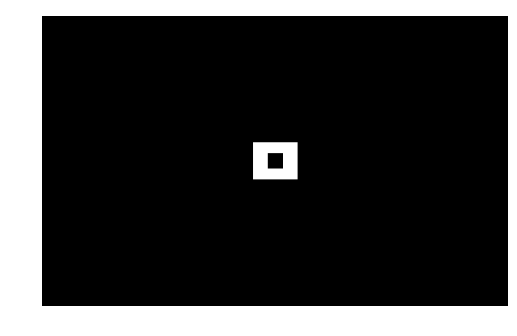

In [48]:
def box_filter( image_array, height, width, inner_height, inner_width ):
    filter_image_array = np.array(image_array, dtype=float)
    filter_image_array.fill(0)
    rows = image_array.shape[0]
    cols = image_array.shape[1]
    print(rows, cols)
    center = ( int(rows / 2), int(cols / 2) )
    top_left     = ( center[0] - int(height / 2), center[1] - int(width / 2) )
    bottom_right = ( center[0] + int(height / 2), center[1] + int(width / 2) )
    
    inner_top_left     = ( center[0] - int(inner_height / 2), center[1] - int(inner_width / 2) )
    inner_bottom_right = ( center[0] + int(inner_height / 2), center[1] + int(inner_width / 2) )

    for row in range(rows):
        if not (top_left[0] <= row and row <= bottom_right[0]):
            continue
        for col in range(cols):
            if top_left[1] <= col and col <= bottom_right[1]:
                if not (inner_top_left[1] <= col and col <= inner_bottom_right[1]) \
                    or (not (inner_top_left[0] <= row and row <= inner_bottom_right[0])):
                        filter_image_array[row][col] = True
                   
    fig1 = plt.figure()
    ax1  = fig1.add_subplot( 111 )
    ax1.axis('off')
    # Usually for viewing purposes:b
    ax1.imshow( filter_image_array, cmap='gray' ) # io.
    plt.show()
    

box_filter( avg_img_array, 50, 60, 20, 20 )

400 640
(200, 320)
134.536240471


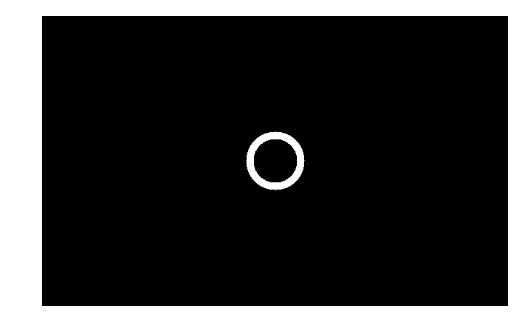

In [13]:
def ring_filter( image_array, radius_outter, radius_inner ):
    filter_image_array = np.array(image_array, dtype=float)
    filter_image_array.fill(0)
    rows = image_array.shape[0]
    cols = image_array.shape[1]
    print( rows, cols )
    center = ( int(rows / 2), int(cols / 2) )
    print( center )
    
    print(np.linalg.norm([100, 230] - np.asarray(center)))
    
    for row in range(rows):
        if not (center[0] - radius_outter <= row and row <= center[0] + radius_outter):
            continue
        for col in range(cols):
            if center[1] - radius_outter <= col and col <= center[1] + radius_outter:
                if np.linalg.norm([row, col] - np.asarray(center)) <= radius_outter:
                    if radius_inner <= np.linalg.norm([row, col] - np.asarray(center)):
                        filter_image_array[row][col] = True

    fig1 = plt.figure()
    ax1  = fig1.add_subplot( 111 )
    ax1.axis('off')
    # Usually for viewing purposes:b
    ax1.imshow( filter_image_array, cmap='gray' ) # io.
    plt.show()
    
ring_filter( avg_img_array, 40, 30 )

In [ ]:
'''
Returns a grayscale image representing a sector filter.

Parameters
----------
    radius  : radius of the sector. 

    theta_1 : the angle between the Ox axis and the right side of the sector.
    
    theta_2 : the angle between the Ox axis and the left side of the sector.
'''
def sector_filter( image_array, radius, theta_1, theta_2, inner_circle_radius=0):
    filter_image_array = np.array(image_array, dtype=float)
    filter_image_array.fill(0)
    rows = image_array.shape[0]
    cols = image_array.shape[1]
    
    center = ( int(rows / 2), int(cols / 2) )
    
    for row in range(rows):
        # Flip the graph by the Ox axis.
        translated_row = -(row - center[0])
        # To avoid division by zero in the computation of atan below.
        if translated_row == 0 or translated_row < 0:
            continue
        for col in range(cols):
            translated_col = col - center[1]
            if (translated_row)**2 + (translated_col)**2 > radius**2:
                continue
            # Inner circle
            dist = euclidean_distance((0, 0), (translated_row, translated_col))
            if dist <= inner_circle_radius:
                continue
            arctg_degrees = math.degrees(math.atan( translated_col / translated_row ) )
            if theta_1 <= arctg_degrees and arctg_degrees <= theta_2:
                # Mark the original, untranslated pixel.
                filter_image_array[row][col] = True
                
    fig1 = plt.figure()
    ax1  = fig1.add_subplot( 111 )
    ax1.axis('off')
    # Usually for viewing purposes:b
    ax1.imshow( filter_image_array, cmap='gray' ) # io.
    plt.show()
    
sector_filter( avg_img_array, 30, 0, 120, 10 )

30.0
29.832867780352597
29.614185789921695
29.427877939124322
29.274562336608895
29.154759474226502
29.068883707497267
29.017236257093817
29.0
29.017236257093817
29.068883707497267
29.154759474226502
29.274562336608895
29.427877939124322
29.614185789921695
29.832867780352597
29.732137494637012
29.410882339705484
29.120439557122072
28.861739379323623
28.635642126552707
28.442925306655784
28.284271247461902
28.160255680657446
28.071337695236398
28.0178514522438
28.0
28.0178514522438
28.071337695236398
28.160255680657446
28.284271247461902
28.442925306655784
28.635642126552707
28.861739379323623
29.120439557122072
29.410882339705484
29.732137494637012
29.966648127543394
29.546573405388315
29.154759474226502
28.792360097775937
28.460498941515414
28.160255680657446
27.892651361962706
27.65863337187866
27.459060435491963
27.294688127912362
27.16615541441225
27.073972741361768
27.018512172212592
27.0
27.018512172212592
27.073972741361768
27.16615541441225
27.294688127912362
27.459060435491963